# Análise exploratória dos tweets e dos dados econômicos


Após a coleta dos dados econômicos e dados do Twitter, uma primeira análise exploratória de dados foi realizada. Com o intuito de explorar relações e padrões presentes nos dados obtidos, diversas visualizações foram realizadas. Segue abaixo a divisão destas por subseção.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Dados econômicos
### Validez dos dados

Primeiramente, para verificar a normalidade dos dados e sua condizência com outros presentes na internet, foi realizado um gráfico básico de Data x Valor para cada índice econômico.

In [3]:
# read economic data
economic_data = pd.read_csv("..//data//economic_data//economic_time_series.csv", sep=";", index_col=0)

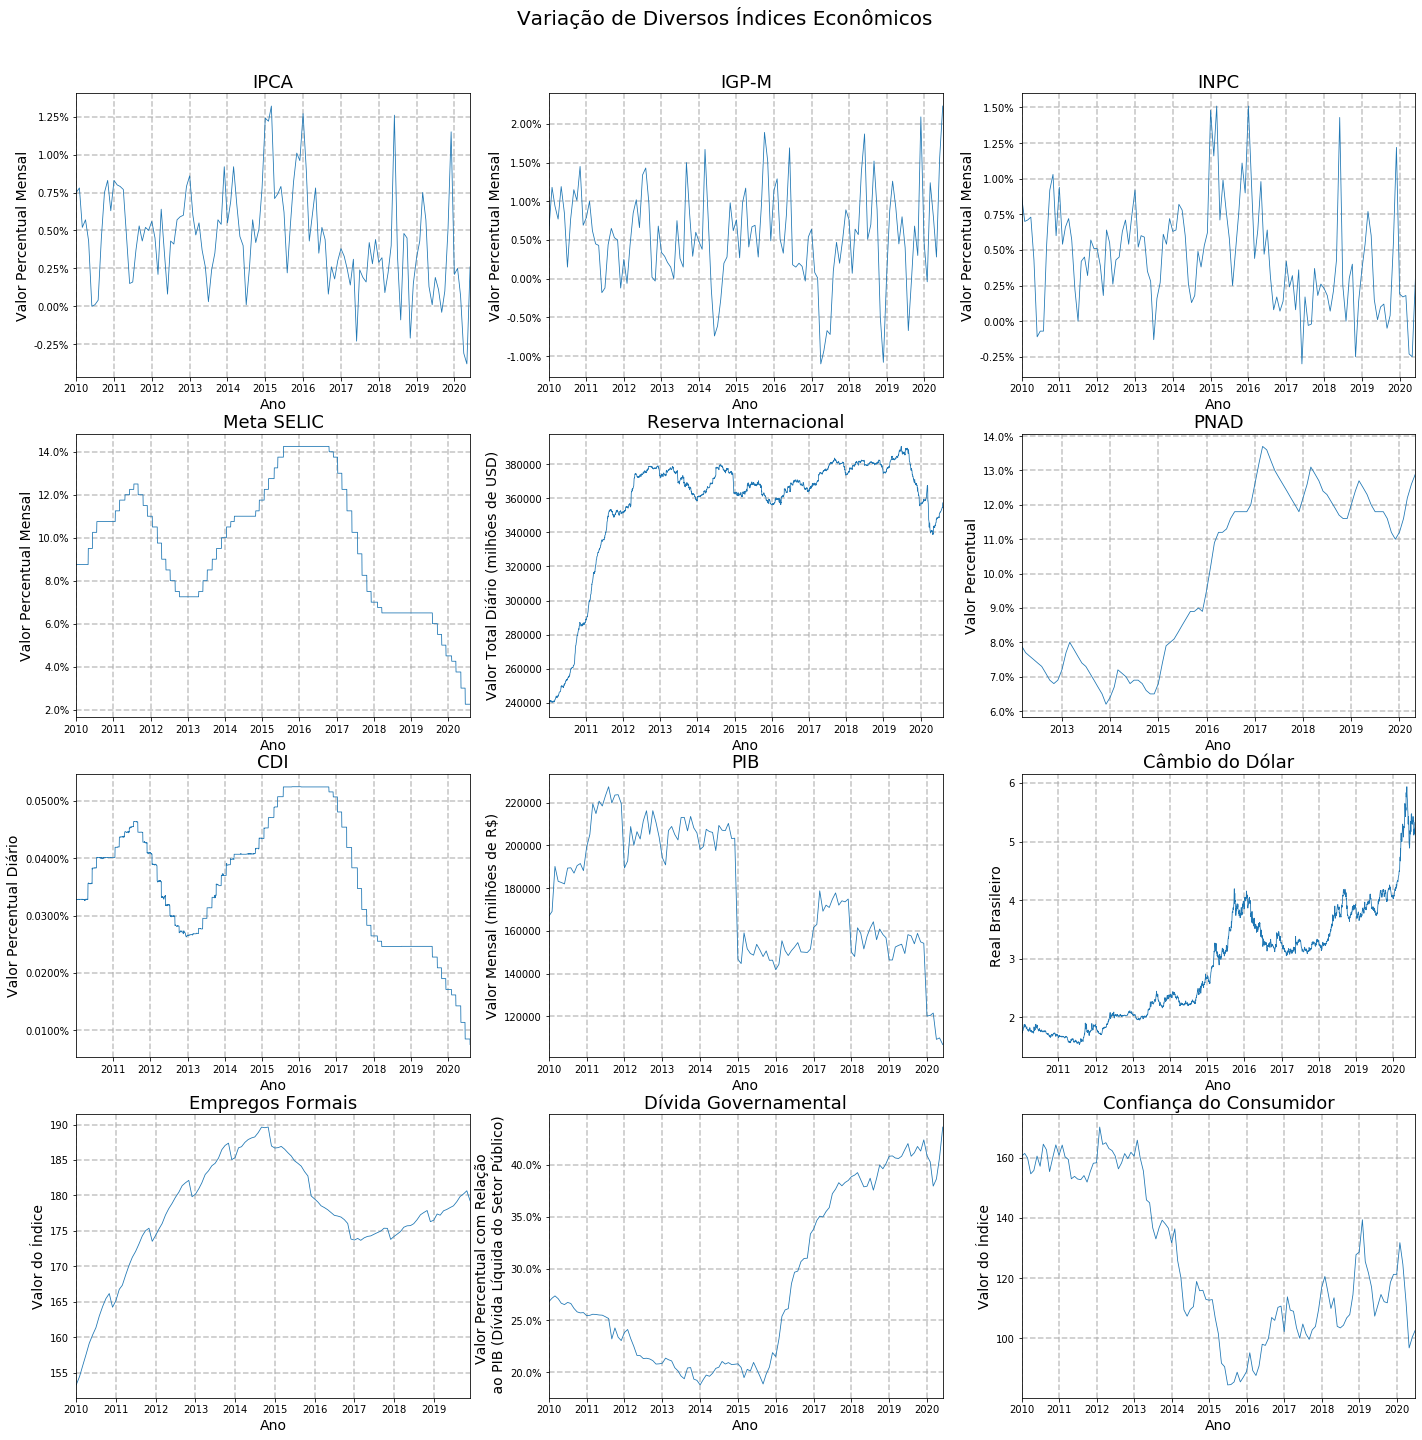

In [ ]:
# Parâmetros úteis
initialDate = '2010-01-01'
indices = list(economic_data.columns)
nColumn = 3
nRows = int(len(indices)/nColumn)

# Y Label, título subplot
dicTitles = {'ipca':['Valor Percentual Mensal','IPCA'],
 'igpm':['Valor Percentual Mensal','IGP-M'],
 'inpc':['Valor Percentual Mensal','INPC'],
 'selic_meta':['Valor Percentual Mensal','Meta SELIC'],
 'international_reserve':['Valor Total Diário (milhões de USD)','Reserva Internacional'],
 'pnad':['Valor Percentual','PNAD'],
 'cdi':['Valor Percentual Diário','CDI'],
 'gdp':['Valor Mensal (milhões de R$)','PIB'],
 'dollar':['Real Brasileiro','Câmbio do Dólar'],
 'employment':['Valor do Índice','Empregos Formais'],
 'gov_debt':['Valor Percentual com Relação \n ao PIB (Dívida Líquida do Setor Público)','Dívida Governamental'],
 'consumer_confidence':['Valor do Índice','Confiança do Consumidor']
}

# Plot
fig, ax = plt.subplots(nRows, nColumn, figsize=(8*nColumn,6*nRows))

for i in range(0,len(indices)):
    # Pegando a informação
    allValues = np.array(economic_data[indices[i]])
    ind = ~np.isnan(allValues) & (np.array(economic_data.index)>=initialDate)
    seriesValues = allValues[ind]
    dateValues = pd.to_datetime(economic_data.index[ind])
    
    # Plotando e formatando
    ax[int(i/nColumn)][i%nColumn].plot(dateValues, seriesValues, lw=0.8)
    ax[int(i/nColumn)][i%nColumn].set_xlim(dateValues.min(), dateValues.max())
    ax[int(i/nColumn)][i%nColumn].set_xlabel('Ano', fontsize=14)
    if 'Percentual' in dicTitles[indices[i]][0]:
        ax[int(i/nColumn)][i%nColumn].set_ylabel(dicTitles[indices[i]][0], fontsize=14)
        ax[int(i/nColumn)][i%nColumn].yaxis.set_major_formatter(PercentFormatter(100))
    else:
        ax[int(i/nColumn)][i%nColumn].set_ylabel(dicTitles[indices[i]][0], fontsize=14)
        
    ax[int(i/nColumn)][i%nColumn].set_title(dicTitles[indices[i]][1], fontsize=18)
    
    ax[int(i/nColumn)][i%nColumn].grid(True, lw=1.5, ls='--', alpha=0.75)
    
# Título do plot
plt.suptitle("Variação de Diversos Índices Econômicos",x=0.5, y=0.93,verticalalignment='top', fontsize = 20)
plt.savefig('images/figure1.pdf')
plt.show();

As principais informações que podemos extrair desta visualização são: que nossos dados são bem-comportados; e as datas onde cada índice econômico está compreendido.

### Análise de correlação

Devido à grande quantidade deste índices e de padrões semelhantes nas subfiguras, uma outra visualização foi realizada. Esta têm como propósito analisar a correlação entre esses valores

In [ ]:
# manter datas acima de 2010
economic_data.index = pd.to_datetime(economic_data.index)
economic_data["year"] = pd.DatetimeIndex(economic_data.index).year
economic_data = economic_data[economic_data.year >= 2010]

# remover as linhas NaN por simplicidade
clean_economic_data = economic_data.dropna()
economic_features = clean_economic_data.columns

# rescale os dados para melhor visualização
scaler = StandardScaler().fit(clean_economic_data);

scaled_economic_data = scaler.transform(clean_economic_data)
scaled_economic_data = pd.DataFrame(scaled_economic_data,
                                    columns=economic_features)

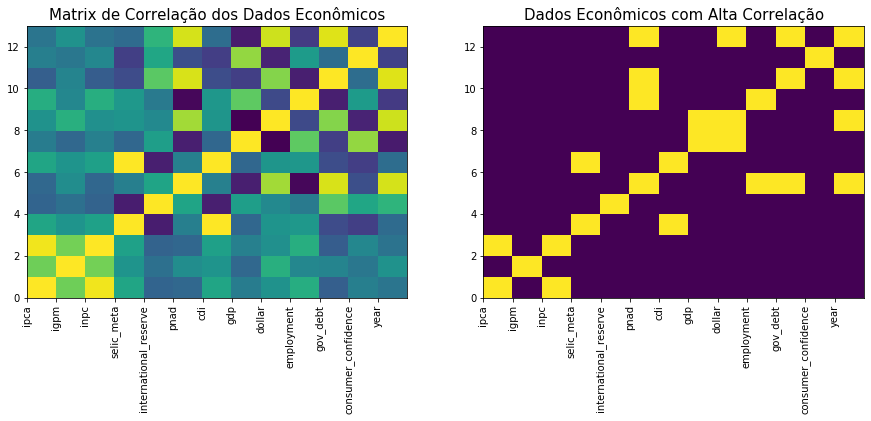

In [ ]:
## plot os dados para mostrar correlação
corr_mat = np.corrcoef(scaled_economic_data.T)
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_xticks(range(len(scaled_economic_data.columns)))
ax[0].set_xticklabels(scaled_economic_data.columns, rotation="vertical")
ax[0].pcolor(corr_mat)
ax[0].set_title("Matrix de Correlação dos Dados Econômicos", fontsize=15)

ax[1].set_xticks(range(len(scaled_economic_data.columns)))
ax[1].set_xticklabels(scaled_economic_data.columns, rotation='vertical')
ax[1].pcolor(abs(corr_mat) > 0.8)
ax[1].set_title("Dados Econômicos com Alta Correlação", fontsize=15)

plt.savefig('..//images//figure2.pdf')
plt.show()

Muitos dados apresentados são fortemente correlacionados, o que se é de esperar: flutuações em fatores econômicos globais influenciam de maneira semelhante índices semelhantes no mercado.

Algumas variáveis possuem também comportamentos opostos, ou *negativamente correlacinados*. Para fins de primeira análise, removemos as variáveis correlacionadas, evitando acúmulo de informação repetida.

In [ ]:
# remover features com alto grau de correlação

to_remove = []
for col_i in range(len(economic_features)):
    for col_j in range(col_i+1, len(economic_features)):
        # se uma feature já esta para remover, continue
        if economic_features[col_j] in to_remove: continue

        # se uma feature está correlacionada com a anterior, remova-a
        if abs(corr_mat[col_i,col_j]) > 0.8 :
            to_remove.append(economic_features[col_j])

# printar resultados
print("De {} indexes, removemos {} deles".format(
    len(economic_features), len(to_remove)))
print("Removidos: ", to_remove)

De 13 indexes, removemos 6 deles
Removidos:  ['inpc', 'cdi', 'employment', 'gov_debt', 'year', 'dollar']


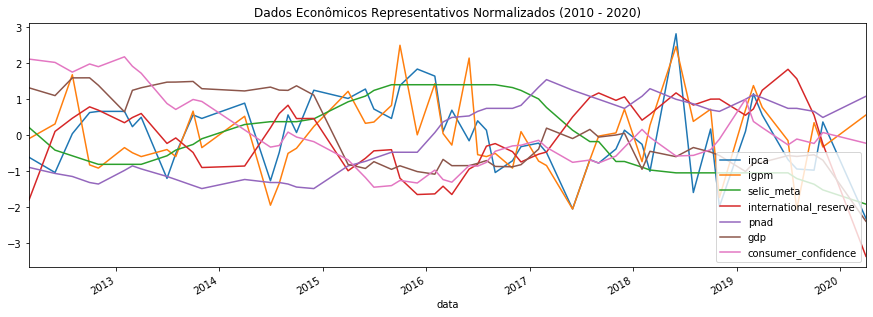

In [ ]:
# usar a versão simplificada dos dados
simp_economic_data = economic_data.drop(to_remove, axis=1)

# remover as linhas NaN por simplicidade
clean_economic_data = simp_economic_data.dropna()
economic_features = clean_economic_data.columns

# rescale os dados para melhor visualização
scaler = StandardScaler().fit(clean_economic_data)
scaled_economic_data = clean_economic_data.copy()
scaled_economic_data[economic_features] = scaler.transform(clean_economic_data)
scaled_economic_data = pd.DataFrame(scaled_economic_data)
scaled_economic_data.columns = economic_features

# plotamos os dados representativos
g = scaled_economic_data.plot(figsize=(15,5))
g.set_title("Dados Econômicos Representativos Normalizados (2010 - 2020)")
plt.savefig('..//images//figure3.pdf')

Resumimos o conjunto de variáveis inicial a 7 representativas, a partir das quais podemos analisar as tendencias do mercado, e considerar impactos de eventos econômicos relevantes em certos períodos como a crise de 2014 e a eleição de Donald Trump em 2016.

## Análise de texto do Twitter

Com o intuito de explorar a influência destas imagens (família Bolsonaro), um gráfico de scatter foi realizado onde $x$ representa a data e $y$ o número de retweets de um tweet daquele dia.

In [ ]:
tweets_data = pd.read_csv("..//data//tweets//preprocessed_tweets.csv", sep="~", index_col=0)
tweets_data["date"] = pd.to_datetime(tweets_data["date"])
tweeys_data = tweets_data.set_index("date")

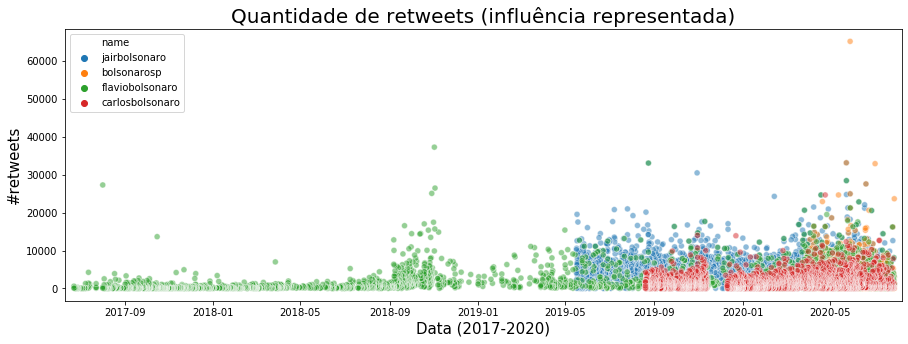

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(x = tweeys_data.index, y = "retweet_count",
                data=tweeys_data, hue="name", alpha=0.5, ax=ax)

ax.set_xlabel("Data (2017-2020)", fontsize=15)
ax.set_ylabel("#retweets", fontsize=15)
ax.set_title("Quantidade de retweets (influência representada)", fontsize=20)
ax.set_xlim('2017-06-10', '2020-08-07')

plt.savefig('..//images//figure4.pdf')
plt.show()

Podemos observar que o Twitter mais influente é o entitulado jairbolsonaro, seguido por flaviobolsonaro e carlosbolsonaro. Nesta imagem também podemos observar a limitação dos dados com relação às datas.

## Discussão de séries temporais: tweets e dados econômicos

Levantamos alguns questionamentos das séries com relação alguns eventos econômicos que podem representar impactos relevantes, assim como a relação de influencia/correlação dos tweets com o mercado.

* Quais eventos entre 2010 e 2020 explicam impactos, ou comportamentos externos nos dados?
* Esses impactos devem ser removidos, ou o mais adequado é mantê-los em análise como explicadores de eventuais correlações com os tweets?
* Como podemos relacionar termos mais frequentes e um período com os fatos econômicos apresentados? Quando termos são anteriores às notícias deveículos importantes no mesmo período, isso prediz impacto dos tweets na economia?

Resumo de algumas notícias na útimas década: https://pt.wikipedia.org/wiki/D%C3%A9cada_de_2010#Cronologia_de_eventos

### Primeira análise

Apesar de ainda não termos realizado a análise sentimental juntamente com outros métodos nos tweets obtidos, uma visualização foi realizada para observar possíveis relações entre o número de tweets e a variação nos índices.

In [ ]:
monthly_tweeys_data = tweeys_data.groupby(['year','month','name']).agg({
    'name': len
})
monthly_tweeys_data.columns = ['numberOfTweets']

economic_data['month'] =economic_data.index.month
monthly_economic_data = economic_data.groupby(['year','month']).agg({
    'ipca': np.mean,
    'igpm': np.mean,
    'inpc': np.mean,
    'selic_meta': np.mean,
    'international_reserve': np.mean,
    'pnad': np.mean,
    'cdi': np.mean,
    'gdp': np.mean,
    'dollar': np.mean,
    'employment': np.mean,
    'gov_debt': np.mean,
    'consumer_confidence': np.mean
})

monthly_tweeys_data = monthly_tweeys_data.reset_index()
monthly_economic_data = monthly_economic_data.reset_index()

monthly_tweeys_data['date'] = [pd.datetime(year=monthly_tweeys_data.iloc[i,0], month=monthly_tweeys_data.iloc[i,1], day=1) 
                               for i in range(0,len(monthly_tweeys_data))]
monthly_economic_data['date'] = [pd.datetime(year=monthly_economic_data.iloc[i,0], month=monthly_economic_data.iloc[i,1], day=1) 
                               for i in range(0,len(monthly_economic_data))]

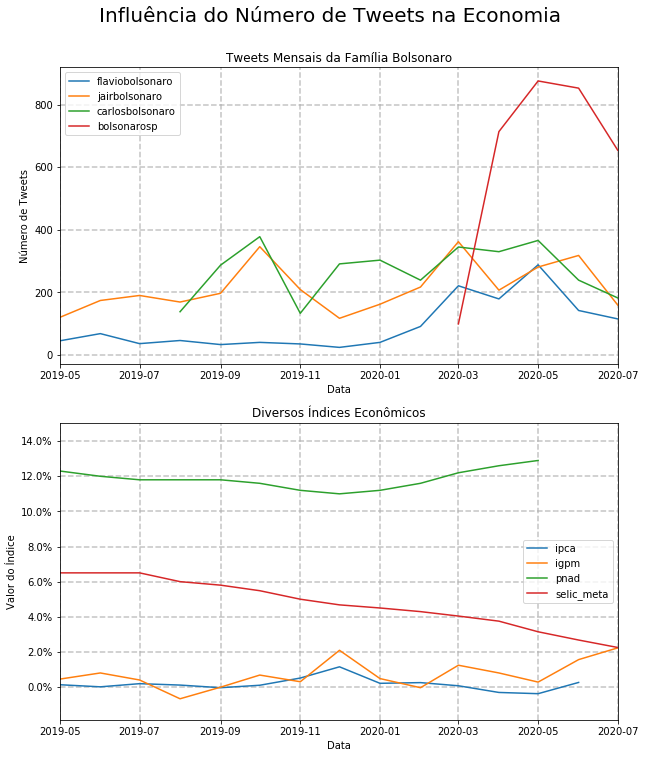

In [ ]:
names = monthly_tweeys_data['name'].unique()
economyIndexesPercentageBased = ['ipca','igpm','pnad','selic_meta']

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10,12))

# Getting the info and plotting
for name in names:
    ax[0].plot(monthly_tweeys_data['date'].loc[monthly_tweeys_data['name']==name], 
            monthly_tweeys_data['numberOfTweets'].loc[monthly_tweeys_data['name']==name], 
            label=name)

# Aesthetics stuff
ax[0].set_xlim('2019-05-01','2020-07-01')
ax[0].set_xlabel('Data')
ax[0].set_ylabel('Número de Tweets')
ax[0].set_title('Tweets Mensais da Família Bolsonaro')
ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[0].legend()

# Getting the info and plotting
for ecoIndex in economyIndexesPercentageBased:
    ind = ~np.isnan(monthly_economic_data[ecoIndex])
    ax[1].plot(monthly_economic_data['date'][ind], 
            monthly_economic_data[ecoIndex][ind], 
            label=ecoIndex)

# Aesthetics stuff
ax[1].set_xlim('2019-05-01','2020-07-01')
ax[1].set_xlabel('Data')
ax[1].set_ylabel('Valor do Índice')
ax[1].set_title('Diversos Índices Econômicos')
ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
ax[1].yaxis.set_major_formatter(PercentFormatter(100))
ax[1].legend()
    
# Overall title
plt.suptitle("Influência do Número de Tweets na Economia",x=0.5, y=0.95,verticalalignment='top', fontsize = 20)
plt.savefig('..//images//figure5.pdf')
plt.show()

Nenhuma correlação foi facilmente observada através deste gráfico, devido aos valores de alguns indicadores estarem disponíveis apenas mensalmente, entre outros motivos. 

## Nuvem de palavras

Desejamos analisar quais os principais assuntos presentes no tweets do perfil do Jair Bolsonaro e também analisar como esses tópicos se alteraram ao longo do tempo, para isso, produziremos nuvens de palavras. Para realizar a visualização de nuvem de palavras utilizaremos a biblioteca __wordcloud__ e a partir dos dados dos tweets do Bolsonaro executaremos uma limpeza para adequar os dados para a biblioteca, para isso é necessário a biblioteca __nltk__ com seu conjunto de _stopwords_ para que não sejam consideradas na visualização.

Como os dados também possuem a dimensão temporal, dividimos o intervalo de junho de $2019$ a julho de $2020$ em $4$ intervalos, e para cada um desses intervalos iremos gerar uma nuvem de palavras distinta, dessa forma, podemos avaliar o comportamento ao longo do tempo.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import nltk
#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

In [ ]:
tweet_df = tweets_data.copy()

bolsonaro_df = tweet_df[tweet_df.name == "jairbolsonaro"]
print("O tweet mais antigo é de ", bolsonaro_df.date.min())
print("O tweet mais recente é de ", bolsonaro_df.date.max())

O tweet mais antigo é de  2019-05-16 17:22:36+00:00
O tweet mais recente é de  2020-07-27 20:51:13+00:00


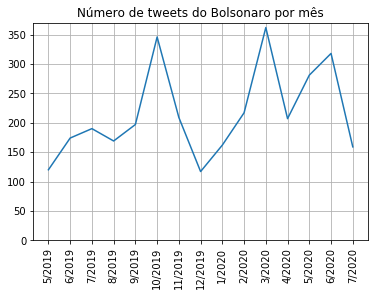

In [ ]:
plot_data = bolsonaro_df.groupby(by = ["year", "month"]).count().reset_index()
plot_data["year-monthly"] = plot_data.month.apply(str) + "/" + plot_data.year.apply(str)
plt.plot(plot_data['year-monthly'], plot_data.full_text)
plt.title("Número de tweets do Bolsonaro por mês")
plt.xticks(rotation = 90)
plt.grid()
plt.ylim((0, 370))
plt.show()

Observando os dados que possuímos, dividiremos em 4 intervalos temporais para produzir 4 nuvens de palavras de cada um desses intervalos. Os intervalos serão:

- Início do dados até 01/09/2019.
- 01/09/2019 até 31/12/2019
- 01/01/2020 até 01/04/2020
- 01/04/2020 até o final dos dados.

In [ ]:
def convert_tweets_to_text(df):
    df = df.full_text.str.lower() #everything lowercase
    df = df.str.replace('^https?:\/\/.*[\r\n]*', '', regex = True) #remove urls
    df = df.str.replace('[^A-zÀ-ú0-9 ]', '', regex = True) #keeps only alphanumerics and space 
    return "".join(df.tolist())

In [ ]:
tweets_start_sep = convert_tweets_to_text(bolsonaro_df[((bolsonaro_df.date.min() < bolsonaro_df.date) 
                                                        & (bolsonaro_df.date < "2019-09-01"))])
tweets_sep_dec = convert_tweets_to_text(bolsonaro_df[(("2019-09-01" <= bolsonaro_df.date) 
                                                     & (bolsonaro_df.date <= "2019-12-31"))])
tweets_jan_mar = convert_tweets_to_text(bolsonaro_df[(("2020-01-01" <= bolsonaro_df.date) 
                                                     & (bolsonaro_df.date < "2020-04-01"))])
tweets_apr_end = convert_tweets_to_text(bolsonaro_df[(("2020-04-01" <= bolsonaro_df.date) 
                                                      & (bolsonaro_df.date <= bolsonaro_df.date.max()))])

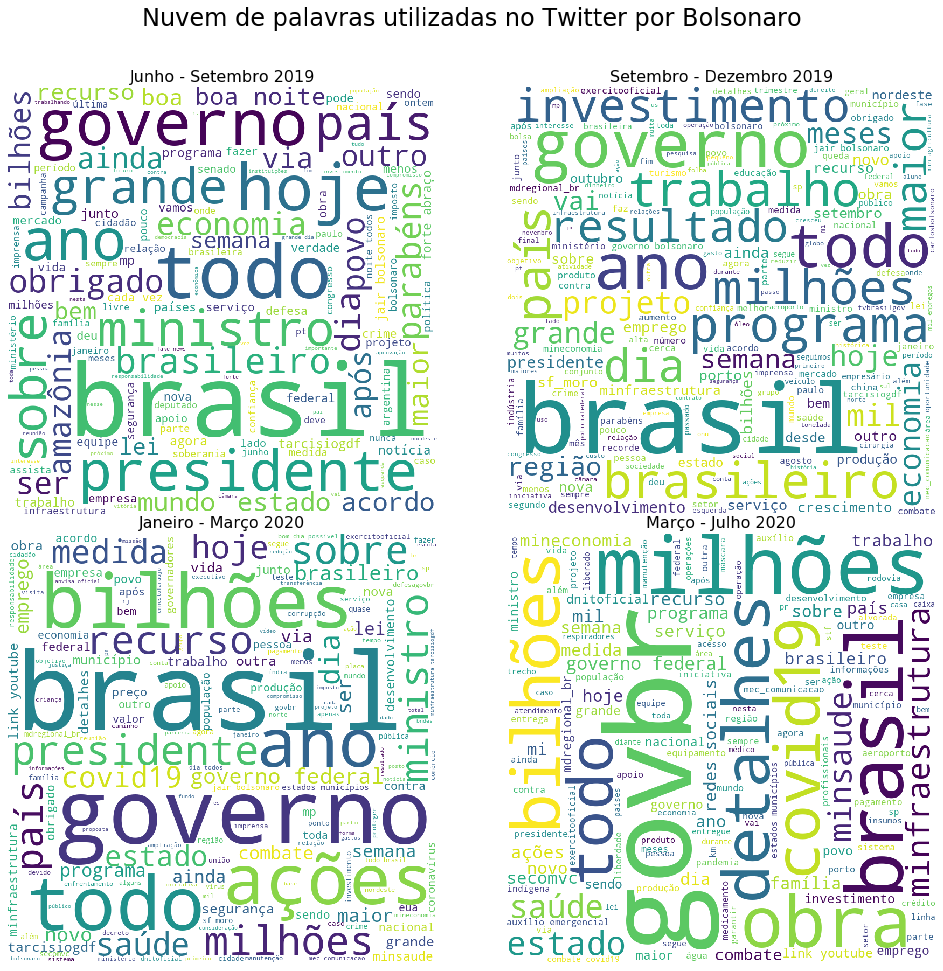

In [ ]:
wordcloud1 = WordCloud(width = 800, height = 800, background_color ='white', 
                      stopwords = stopwords, min_font_size = 10).generate(tweets_start_sep) 
wordcloud2 = WordCloud(width = 800, height = 800, background_color ='white', 
                      stopwords = stopwords, min_font_size = 10).generate(tweets_sep_dec)
wordcloud3 = WordCloud(width = 800, height = 800, background_color ='white', 
                      stopwords = stopwords, min_font_size = 10).generate(tweets_jan_mar) 
wordcloud4 = WordCloud(width = 800, height = 800, background_color ='white', 
                      stopwords = stopwords, min_font_size = 10).generate(tweets_apr_end) 
# plot the WordCloud images               
fig = plt.figure(figsize = (14, 14), facecolor = None) 
#fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.suptitle("Nuvem de palavras utilizadas no Twitter por Bolsonaro", fontsize=24, y = 0.95)
ax1 = plt.subplot(221)
plt.imshow(wordcloud1)
plt.axis("off") 
ax1.set_title("Junho - Setembro 2019",  fontsize=16)
ax2 = plt.subplot(222)
plt.imshow(wordcloud2) 
plt.axis("off") 
ax2.set_title("Setembro - Dezembro 2019",  fontsize=16)
ax3 = plt.subplot(223)
plt.imshow(wordcloud3)
plt.axis("off") 
ax3.set_title("Janeiro - Março 2020",  fontsize=16)
ax4 = plt.subplot(224)
plt.imshow(wordcloud4) 
plt.axis("off") 
ax4.set_title("Março - Julho 2020",  fontsize=16)
plt.tight_layout(pad = 0.05) 
plt.subplots_adjust(top=0.87)
plt.savefig('..//images//wordcloud.pdf', pad_inches = 1)
plt.show() 

Podemos observar que no ano de $2020$ surge "covid19" como um dos principais temas. Além disso, no primeiro intervalo observamos temas mais gerais ainda com posições de período eleitoral, enquanto no intervalo de setembro a dezembro de $2019$, tópicos como "programa", "investimento", "trabalho", "resultado", "emprego", indicando o início da discussão de propostas do governo Bolsonaro.